In [95]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('../data/processed/processed_data.csv')

# X, y = df.iloc[:, list(range(0, 10)) + list(range(38, 49))], df.iloc[:, 49:]
X, y = df.iloc[:, :49], df.iloc[:, 49:]

# split the multi-labels into train and test
y_train = y.iloc[:int(len(y) * 0.8), :]
y_test = y.iloc[int(len(y) * 0.8):, :]
X_train = X.iloc[:int(len(X) * 0.8), :]
X_test = X.iloc[int(len(X) * 0.8):, :]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(114890, 49) (114890, 7) (28723, 49) (28723, 7)


In [96]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
print(f'Train score: {rf.score(X_train, y_train)}')

# print f1 score
from sklearn.metrics import f1_score
print(f'Test score: {f1_score(y_test, rf.predict(X_test), average="micro")}')

Train score: 0.9974497345286796
Test score: 0.8018619084561676


<AxesSubplot: >

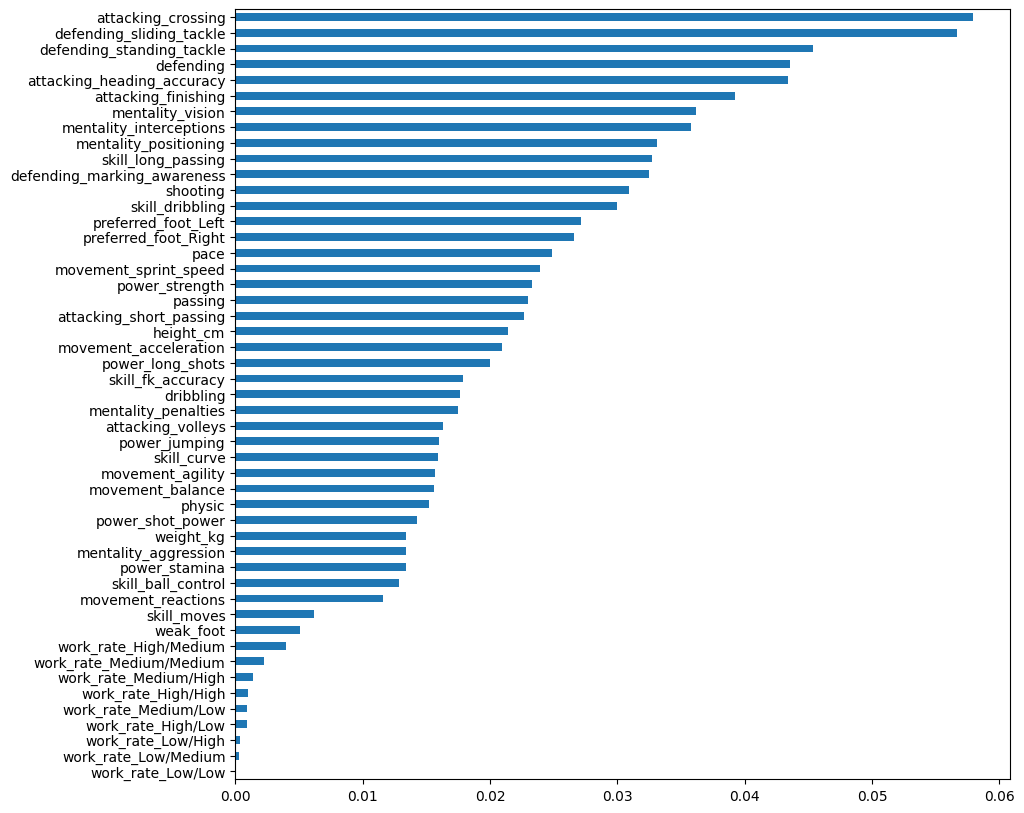

In [97]:
# draw feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot.barh(ax=ax)

In [98]:
X_test.head()
y_test.head()

# 110 columns in the dataset
# 160k+ rows
pd.set_option('display.max_columns', 110)
pd.set_option('display.max_rows', 1000)

y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)


In [99]:

# display the first 100 rows highlighting the 1s
y_pred.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')


,ST,LW,RW,CM,RB,LB,CB
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0
6,0,1,1,0,0,0,0
7,0,0,0,0,0,0,1
8,0,0,0,1,0,0,0
9,0,0,0,0,0,1,0


In [100]:
# display the first 100 rows highlighting the 1s
y_test.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')


,ST,LW,RW,CM,RB,LB,CB
114890,1,1,0,0,0,0,0
114891,0,0,0,1,0,0,0
114892,0,0,0,1,0,0,0
114893,0,0,0,0,0,0,1
114894,0,1,0,1,0,0,0
114895,0,0,0,1,0,0,0
114896,1,1,1,0,0,0,0
114897,0,0,0,1,0,0,0
114898,0,0,0,1,0,0,0
114899,0,0,0,0,0,1,0


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               6400      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 7)                 455       
                                                                 
Total params: 15,111
Trainable params: 15,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/home/ahmed/anaconda3/envs/cmps460/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


920/920 [==============================] - 1s 1ms/step - loss: 0.2991 - accuracy: 0.6002 - val_loss: 0.2221 - val_accuracy: 0.7088
Epoch 2/100
920/920 [==============================] - 1s 1ms/step - loss: 0.2376 - accuracy: 0.6759 - val_loss: 0.2113 - val_accuracy: 0.7075
Epoch 3/100
920/920 [==============================] - 1s 1ms/step - loss: 0.2290 - accuracy: 0.6830 - val_loss: 0.2054 - val_accuracy: 0.6987
Epoch 4/100
920/920 [==============================] - 1s 1ms/step - loss: 0.2260 - accuracy: 0.6861 - val_loss: 0.2048 - val_accuracy: 0.7050
Epoch 5/100
920/920 [==============================] - 1s 1ms/step - loss: 0.2240 - accuracy: 0.6882 - val_loss: 0.2032 - val_accuracy: 0.7135
Epoch 6/100
920/920 [==============================] - 1s 968us/step - loss: 0.2221 - accuracy: 0.6893 - val_loss: 0.2011 - val_accuracy: 0.7082
Epoch 7/100
920/920 [==============================] - 1s 984us/step - loss: 0.2216 - accuracy: 0.6927 - val_loss: 0.2025 - val_accuracy: 0.7093
Epoch 8

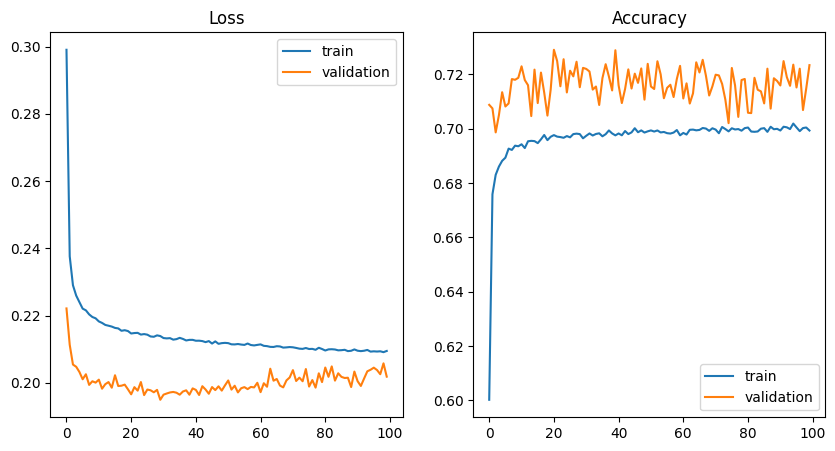

In [101]:
# use ANN to predict the multi-labels
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2)

# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='validation')
ax[1].set_title('Accuracy')
ax[1].legend()


In [102]:
# evaluate the model
model.evaluate(X_test, y_test)

# predict the test set
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)

# display the first 100 rows highlighting the 1s
y_pred.head(10).style.applymap(lambda x: 'background-color : yellow' if x > 0.5 else '')


898/898 [==============================] - 0s 383us/step


,ST,LW,RW,CM,RB,LB,CB
0,0.826886,0.240162,0.232345,0.459189,0.000458,0.000162,0.000008
1,0.000529,0.001829,0.005903,0.889138,0.049345,0.011248,0.534620
2,0.000293,0.009325,0.026802,0.884512,0.194781,0.053434,0.247433
3,0.000278,0.000340,0.000782,0.109969,0.133215,0.037947,0.995682
4,0.005874,0.648104,0.056934,0.326089,0.005209,0.874658,0.005618
5,0.052204,0.240562,0.284260,0.953992,0.033052,0.010526,0.002253
6,0.067715,0.866486,0.444181,0.145382,0.002218,0.168854,0.000010
7,0.000212,0.001489,0.004041,0.354788,0.134543,0.035413,0.911217
8,0.007004,0.044951,0.080258,0.984974,0.030590,0.009677,0.008128
9,0.000915,0.626848,0.016852,0.018112,0.037830,0.988779,0.010200


In [104]:
# display the first 100 rows highlighting the 1s
y_test.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')

,ST,LW,RW,CM,RB,LB,CB
114890,1,1,0,0,0,0,0
114891,0,0,0,1,0,0,0
114892,0,0,0,1,0,0,0
114893,0,0,0,0,0,0,1
114894,0,1,0,1,0,0,0
114895,0,0,0,1,0,0,0
114896,1,1,1,0,0,0,0
114897,0,0,0,1,0,0,0
114898,0,0,0,1,0,0,0
114899,0,0,0,0,0,1,0


In [ ]:
# display y train
X_train.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')